In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from dotenv import load_dotenv
load_dotenv();

In [4]:
import os
import numpy as np
import pandas as pd

In [5]:
os.environ['NHL_DATA_DIR'] = './NHL_DATA_DIR' 
print(os.getenv('NHL_DATA_DIR'))

./NHL_DATA_DIR


In [6]:
import src.features.build_features as FeaturesManager

In [7]:
seasons_year = [2015, 2016, 2017, 2018]
df = FeaturesManager.build_features(seasons_year)

In [8]:
df

,Game ID,Event Index,Period,Team,Type,Shot Type,Shooter,Goalie,Strength,X,...,Last event st_Y,Shot distance,Shot angle,Is Goal,Is Empty,Game seconds,Last event angle,Rebound,Change in Shot Angle,Speed From Previous Event
0,2015020001,24,1,Montréal Canadiens (MTL),GOAL,Wrist Shot,Max Pacioretty,Jonathan Bernier,Even,63.0,...,-39.0,37.483330,-46.080924,1,0,189,-18.434949,False,0.000000,3.824492
1,2015020001,123,2,Toronto Maple Leafs (TOR),GOAL,Deflected,James van Riemsdyk,Carey Price,Power Play,-73.0,...,-18.0,162.003086,-0.353673,1,0,1219,-5.648247,False,0.000000,4.374802
2,2015020001,288,3,Montréal Canadiens (MTL),GOAL,Snap Shot,Alex Galchenyuk,Jonathan Bernier,Even,67.0,...,13.0,22.000000,0.000000,1,0,3122,14.574216,True,14.574216,15.435349
3,2015020001,329,3,Montréal Canadiens (MTL),GOAL,Wrist Shot,Max Pacioretty,Brian Flynn,Even,52.0,...,-22.0,37.215588,6.170175,1,1,3569,-7.926927,False,0.000000,15.470234
4,2015020001,7,1,Toronto Maple Leafs (TOR),SHOT,Wrist Shot,Brad Boyes,Carey Price,NaN,-55.0,...,34.0,34.525353,-10.007980,0,0,51,10.525108,False,0.000000,14.025066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305855,2018021271,269,3,Colorado Avalanche (COL),SHOT,Wrist Shot,Derick Brassard,Martin Jones,NaN,-60.0,...,22.0,33.120990,-28.886582,0,0,3242,47.726311,False,0.000000,9.762812
305856,2018021271,276,3,San Jose Sharks (SJS),SHOT,Slap Shot,Joe Pavelski,Semyon Varlamov,NaN,67.0,...,35.0,29.068884,-40.815084,0,0,3337,30.256437,False,0.000000,2.000918
305857,2018021271,281,3,Colorado Avalanche (COL),SHOT,Wrist Shot,Gabriel Landeskog,Martin Jones,NaN,-78.0,...,22.0,11.045361,-5.194429,0,0,3393,47.726311,False,0.000000,0.851661
305858,2018021271,291,3,Colorado Avalanche (COL),SHOT,Wrist Shot,Gabriel Landeskog,Martin Jones,NaN,-82.0,...,-4.0,12.206556,-55.007980,0,0,3519,-12.528808,False,0.000000,0.659472


In [9]:
# DO NOT MODIFY!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader , TensorDataset
import itertools
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *

In [11]:
from tqdm.notebook import tqdm

In [12]:
columns_erase =['Game ID', 'Event Index', 'st_X','st_Y','Last event st_X','Last event st_Y',
                'Strength','Last event angle','Change in Shot Angle','Speed From Previous Event','Team','Shooter',
               'Goalie','Type','Shot Type','Last event type']
df.drop(columns_erase, axis=1, inplace=True)

In [13]:
df2=df.dropna().reset_index(drop=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302885 entries, 0 to 302884
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Period                   302885 non-null  int64  
 1   X                        302885 non-null  float64
 2   Y                        302885 non-null  float64
 3   Last event X             302885 non-null  float64
 4   Last event Y             302885 non-null  float64
 5   Last event elapsed time  302885 non-null  int64  
 6   Last event distance      302885 non-null  float64
 7   Shot distance            302885 non-null  float64
 8   Shot angle               302885 non-null  float64
 9   Is Goal                  302885 non-null  int64  
 10  Is Empty                 302885 non-null  int64  
 11  Game seconds             302885 non-null  int64  
 12  Rebound                  302885 non-null  bool   
dtypes: bool(1), float64(7), int64(5)
memory usage: 28.0 MB


In [14]:
X,y = df2.drop(['Is Goal'], axis = 1), df2['Is Goal']

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [16]:
X_train.shape

(242308, 12)

In [17]:
scaler = MinMaxScaler()

In [18]:
X_train = scaler.fit_transform(X_train.values)
X_val =  scaler.fit_transform(X_val.values)

In [19]:
x_tensor =  torch.from_numpy(X_train).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xval_tensor =  torch.from_numpy(X_val).float()
yval_tensor =  torch.from_numpy(y_val.values.ravel()).float()

In [20]:
batch_size = 64
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_dl = DataLoader(train_ds, batch_size=batch_size)

In [21]:
yval_tensor = yval_tensor.unsqueeze(1)
val_ds = TensorDataset(xval_tensor, yval_tensor)
val_loader = DataLoader(val_ds, batch_size=batch_size)

In [22]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(12, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16,1),
        nn.Sigmoid()
    )


    def forward(self, x):
        return self.layers(x)

In [23]:
model = MLP().to(device)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [24]:
loss_func = nn.BCELoss()
#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 5

In [25]:
train_loss_list = []
val_loss_list =[]
y_val_list = []
f1_train_list = []
f1_val_list = []
best_metric = -1
best_metric_epoch = -1
accuracy_train_list = []
accuracy_val_list = []

for epoch in tqdm(range(epochs)):
    #Within each epoch run the subsets of data = batch sizes.
    model.train()
    train_loss = 0
    train_metric = 0
    correct = 0
    for batch_data in tqdm(train_dl):
        xb , yb = batch_data
        xb , yb = (xb.to(device) , yb.to(device))
        y_pred = model(xb)            # Forward Propagation
        loss = loss_func(y_pred, yb)  # Loss Computation
        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        loss.backward()               # Back Propagation
        optimizer.step()
        train_loss += loss.item()
        temp = y_pred.detach().cpu().numpy()
        train_metric += f1_score(yb.detach().cpu().numpy(),np.where(temp == max(temp),1,0)) 
        correct += (torch.argmax(y_pred,dim=1) == yb.squeeze()).float().sum().item()/batch_size
    train_loss_list.append(train_loss/ len(train_dl))
    f1_train_list.append(train_metric / len(train_dl))
    accuracy_train_list.append(100 * correct / len(train_dl))
    print("Train Loss in iteration :"+str(epoch+1)+" is: "+str(train_loss/ len(train_dl)))
    print("Train f1-score in iteration :"+str(epoch+1)+" is: "+str(train_metric / len(train_dl)))
    print("Train accuracy in iteration :"+str(epoch+1)+" is: "+str(100 * correct / len(train_dl)))
    
    model.eval()
    with torch.inference_mode():
      val_loss = 0
      val_metric = 0
      correct = 0
      for batch_data  in val_loader:
        xb_val , yb_val = batch_data
        xb_val , yb_val = (xb_val.to(device) , yb_val.to(device))
        y_val_pred = model(xb_val)
        loss = loss_func(y_val_pred, yb_val)
        val_loss += loss.item()
        temp = y_val_pred.detach().cpu().numpy()
        val_metric += f1_score(yb_val.detach().cpu().numpy(),np.where(temp == max(temp),0,1)) 
        correct += (torch.argmax(y_val_pred,dim=1) == yb_val.squeeze()).float().sum().item()/batch_size
      val_loss_list.append(val_loss/len(val_loader))
      f1_val_list.append(val_metric/len(val_loader))
      accuracy_val_list.append(100 * correct / len(val_loader))
      print("Val Loss in iteration :"+str(epoch+1)+" is: "+str(val_loss/ len(val_loader)))
      print("Val f1-score in iteration :"+str(epoch+1)+" is: "+str(val_metric / len(val_loader)))
      print("Val accuracy in iteration :"+str(epoch+1)+" is: "+str(100 * correct / len(val_loader)))
    
    if val_metric / len(val_loader) > best_metric:
      best_metric = val_metric / len(val_loader)
      best_metric_epoch = epoch
      torch.save(model.state_dict(), 'best_model_metric.pth')


print('Best f1-score : ', best_metric)
print('Epoch of best f1-score:', best_metric_epoch)


    


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3787 [00:00<?, ?it/s]

Train Loss in iteration :1 is: 0.28615570117741357
Train f1-score in iteration :1 is: 0.14940445325741655
Train accuracy in iteration :1 is: 90.6027198310008
Val Loss in iteration :1 is: 0.2748786384650873
Val f1-score in iteration :1 is: 0.1573371293393687
Val accuracy in iteration :1 is: 90.57880147835269


  0%|          | 0/3787 [00:00<?, ?it/s]

Train Loss in iteration :2 is: 0.2730288582293015
Train f1-score in iteration :2 is: 0.15568249291280004
Train accuracy in iteration :2 is: 90.6027198310008
Val Loss in iteration :2 is: 0.2716891063060592
Val f1-score in iteration :2 is: 0.15721341587113305
Val accuracy in iteration :2 is: 90.57880147835269


  0%|          | 0/3787 [00:00<?, ?it/s]

Train Loss in iteration :3 is: 0.27088250870444325
Train f1-score in iteration :3 is: 0.15649376684263738
Train accuracy in iteration :3 is: 90.6027198310008
Val Loss in iteration :3 is: 0.2698192297586229
Val f1-score in iteration :3 is: 0.15685183543731054
Val accuracy in iteration :3 is: 90.57880147835269


  0%|          | 0/3787 [00:00<?, ?it/s]

Train Loss in iteration :4 is: 0.26995494410076903
Train f1-score in iteration :4 is: 0.1581266643561794
Train accuracy in iteration :4 is: 90.6027198310008
Val Loss in iteration :4 is: 0.2693074713003799
Val f1-score in iteration :4 is: 0.15651113902442088
Val accuracy in iteration :4 is: 90.57880147835269


  0%|          | 0/3787 [00:00<?, ?it/s]

Train Loss in iteration :5 is: 0.2695022767539039
Train f1-score in iteration :5 is: 0.16063096037116992
Train accuracy in iteration :5 is: 90.6027198310008
Val Loss in iteration :5 is: 0.26903380421329576
Val f1-score in iteration :5 is: 0.1563083227849075
Val accuracy in iteration :5 is: 90.57880147835269
Best f1-score :  0.1573371293393687
Epoch of best f1-score: 0


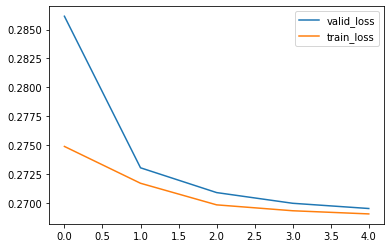

In [27]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label='valid_loss')
plt.plot(val_loss_list, label = 'train_loss')
plt.legend()
plt.show()